[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/3-Intro-Vision/3-10-Deteccion-HoG-SVM-rostros.ipynb)

# Ejemplo: Detección de Rostros con HoG

En este ejemplo se seguirá los siguientes pasos:

* Obtener imágenes positivas y negativas para entrenamiento
* Extraer características HoG (Histogram of Oriented Gradients) de cada imagen del conjunto de entrenamiento
* Entrenar un clasificador SVM usando estas características
* Dada una imagen de prueba, deslizar "ventanas" por la imagen para encontrar si hay un rostro


In [1]:
import matplotlib.pyplot as plt
import numpy as np

## 0.&nbsp;Ejemplo de características HOG en una imagen

In [2]:
from skimage import data, color, feature
import skimage.data

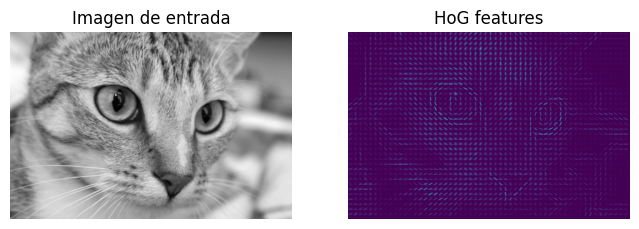

In [3]:
# Ejemplo de una imagen ("chelsea") de la base de datos llamada "data": covertida a escala de grises
I = color.rgb2gray(data.chelsea())

# Extracción de características HOG
vector_HOG, I_HOG = feature.hog(I, visualize=True)

# Visualización de las imágenes
plt.subplots(1, 2, figsize=(8, 6))
# Izquierda: imagen original
plt.subplot(1,2,1)
plt.imshow(I, cmap='gray'); plt.title('Imagen de entrada'); plt.axis('off')
# Derecha: imagen HOG
plt.subplot(1,2,2)
plt.imshow(I_HOG); plt.title('HoG features'); plt.axis('off');

In [4]:
# Vector HOG resultante
print("Tamaño del vector HOG:", vector_HOG.shape)
print("Vector HOG:", vector_HOG)

Tamaño del vector HOG: (153090,)
Vector HOG: [0.02976316 0.         0.         ... 0.00032657 0.         0.        ]


## 1.&nbsp;Generación del Conjunto de Entrenamiento

**Muestras (imágenes) positivas** para el entrenamiento: se considerará las imágenes del dataset LFW

In [5]:
# Conjunto de imágenes: Labeled Faces in the Wild (LFW)
from sklearn.datasets import fetch_lfw_people

# Cargar la base de datos
faces = fetch_lfw_people()

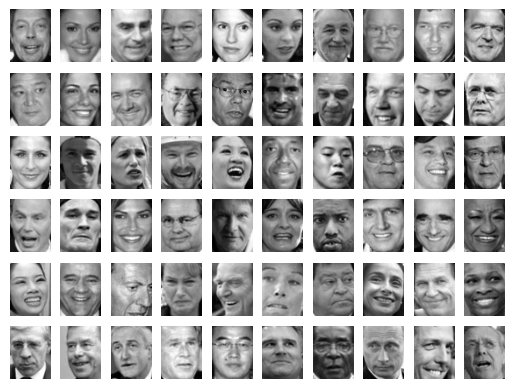

In [6]:
# Muestras (imágenes) positivas para el entrenamiento: contienen rostros
I_positive = faces.images
I_positive.shape

# Gráfico de algunas imágenes positivas
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(I_positive[100*i], cmap='gray'); axi.axis('off')

In [7]:
# Tamaño del conjunto de imágenes "positivas"
print("Tamaño de imágenes positivas:", I_positive.shape)

Tamaño de imágenes positivas: (13233, 62, 47)


**Muestras (imágenes) negativas** para el entrenamiento: no contienen rostros. Se extraerá regiones ("patches") arbitrarios de imágenes genéricas. Específicamente: de las imágenes negativas, se toma "patches" con la mitad del tamaño (0.5), igual tamaño (1.0) y el doble de tamaño (2.0) que las imágenes positivas. Luego todas se re escalan al tamaño de las imágenes positivas.

In [8]:
# Nombres de las imágenes a utilizar (de las que se extraerá regiones)
nombres_imgs = ['camera', 'text', 'coins', 'moon', 'page', 'clock',
                'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']

# Imágenes de las que se extraerá regiones
Imgs = []
for name in nombres_imgs:
    img = getattr(data, name)()
    if (len(img.shape)==3):
        img = color.rgb2gray(img)
    Imgs.append(img)

In [9]:
# Extracción de regiones ("patches") de las imágenes negativas
from sklearn.feature_extraction.image import PatchExtractor
from skimage import transform

# Función para extraer los "patches"
def extract_patches(I, N, scale=1.0, psize=None):
    # Definir el tamaño del patch
    patch_size = tuple((scale*np.array(psize)).astype(int))
    # Extractor de patches
    pextractor = PatchExtractor(patch_size=patch_size, max_patches=N, random_state=0)
    # Extracción de patches a la imagen
    patches = pextractor.transform(I[np.newaxis])
    # Si patches de tamaño diferente que el tamaño de los patches positivos:
    # re-escalar al tamaño de los patches positivos
    if scale != 1:
        patches = np.array([transform.resize(patch, psize) for patch in patches])
    return patches

# Imágenes negativas: se usa patches de 0.5, 1.0 y 2.0 el tamaño del patch positivo
I_negative = np.vstack([extract_patches(im, 1000, scale, psize=I_positive[0].shape)
                        for im in Imgs for scale in [0.5, 1.0, 2.0]] )

# Tamaño del conjunto "negativo"
print("Tamaño de imágenes negativas:", I_negative.shape)

Tamaño de imágenes negativas: (30000, 62, 47)


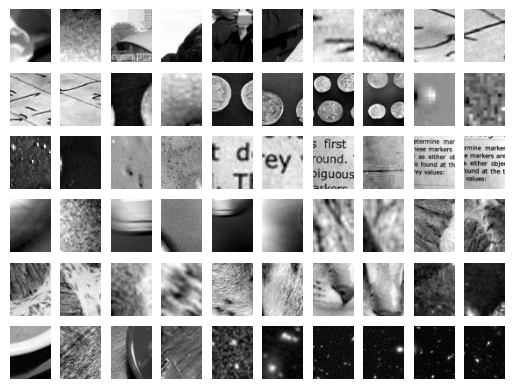

In [10]:
# Gráfico de las imágenes negativas
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(I_negative[500*i], cmap='gray')
    axi.axis('off')

## 2.&nbsp;Uso de HOG y Combinación de los datos (positivos y negativos)

In [11]:
from itertools import chain

# Obtención de atributos HOG para cada imagen positiva y negativa
X_train = np.array([feature.hog(img) for img in chain(I_positive, I_negative)])

# Etiquetas para los atributos
y_train = np.zeros(X_train.shape[0])
y_train[:I_positive.shape[0]] = 1

In [12]:
print("Número de instancias de entrenamiento:", X_train.shape[0])
print("Numero de atributos (tamaño de cada vector de características HOG):", X_train.shape[1])
print("Tamaño del vector de entrada X:", X_train.shape)

Número de instancias de entrenamiento: 43233
Numero de atributos (tamaño de cada vector de características HOG): 1215
Tamaño del vector de entrada X: (43233, 1215)


## 3.&nbsp;Entrenamiento usando SVM

In [19]:
# Clasificador SVM (SVC = Support Vector Classifier)
from sklearn.svm import LinearSVC
# Se usará grid search para encontrar los mejores parámetros
from sklearn.model_selection import GridSearchCV

# Generador de grid search con diferentes valores de "C"
grid = GridSearchCV(LinearSVC(max_iter=2000), {'C': [1.0, 2.0, 4.0]});

# Aplicación de los datos a grid search
grid.fit(X_train, y_train);

In [20]:
# Mejores resultados
print("Mejor score obtenido:", grid.best_score_)
print("Mejores parámetros:", grid.best_params_)

# Se usará el mejor modelo obtenido con Grid Search
modelo = grid.best_estimator_

# Entrenamiento del mejor modelo obtenido
modelo.fit(X_train, y_train);

Mejor score obtenido: 0.9887817015824171
Mejores parámetros: {'C': 2.0}


## 4.&nbsp;Prueba usando una nueva imagen

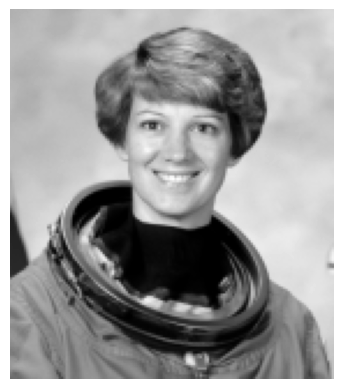

In [21]:
# Imagen de prueba (astronaut del dataset de skimage)
I_test = data.astronaut()

# Convertir la imagen de RGB a escala de grises
I_test = color.rgb2gray(I_test)
# Reducir el tamaño de la imagen
I_test = transform.rescale(I_test, 0.5)
# Extraer solo una parte de la imagen
I_test = I_test[:160, 40:180]

# Mostrar la imagen
plt.imshow(I_test, cmap='gray')
plt.axis('off');

In [22]:
# Define "ventanas deslizantes" en la imagen
def sliding_window(I, scale=1.0, patch_size=None, istep=2, jstep=2):
    Ni, Nj = (int(scale*s) for s in patch_size)
    for i in range(0, I.shape[0]-Ni, istep):
        for j in range(0, I.shape[1]-Ni, jstep):
            patch = I[i: i+Ni, j:j+Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i,j), patch

# Obtención de patches usando "ventanas deslizantes" a lo largo de la imagen
indices, patches = zip(*sliding_window(I_test, patch_size=I_positive[0].shape))

# Aplicación de HOG a cada patch: X de prueba
X_test = np.array([feature.hog(patch) for patch in patches])

print("Número de patches de prueba(Xtest):", len(patches))
print("Tamaño de cada vector de atributos HOG:", X_test.shape[1])
print("Tamaño de X de prueba:", X_test.shape)

Número de patches de prueba(Xtest): 1911
Tamaño de cada vector de atributos HOG: 1215
Tamaño de X de prueba: (1911, 1215)


In [23]:
# Prediicción de rostro en el conjunto de prueba (patches de la imagen de prueba)
y_test = modelo.predict(X_test)

print("Número de ventanas que contienen rostro:", y_test.sum())

Número de ventanas que contienen rostro: 46.0


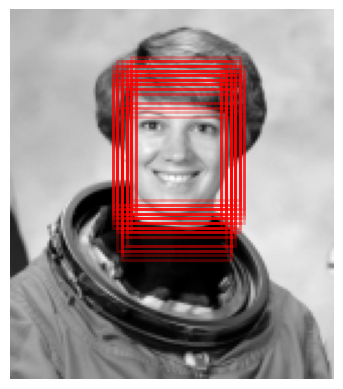

In [24]:
# Gráfico de la imagen
fig, ax = plt.subplots()
ax.imshow(I_test, cmap='gray'); ax.axis('off')

# Tamaño original de los patches
Ni, Nj = I_positive[0].shape
# Índices
indices = np.array(indices)

# Bucle para aquellos índices donde se detecta un rostro (y_test=1)
for i, j in indices[y_test == 1]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))